# 네이버 영화 리뷰 감성 분류하기 (Naver Movie Review Sentiment Analysis)

* 총 200,000개의 리뷰 데이터
* 부정리뷰 : 0, 긍정리뷰 : 1
* 데이터 다운로드 : https://github.com/e9t/nsmc/

# 1. 데이터 준비하기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import re

In [2]:
# 데이터 다운로드 (훈련데이터, 테스트데이터)
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f4b5e5acc50>)

In [3]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [4]:
print(train_data.shape)
print(test_data.shape)

(150000, 3)
(50000, 3)


In [5]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [6]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [7]:
# 긍정리뷰, 부정리뷰 분포 확인
train_data['label'].value_counts()

0    75173
1    74827
Name: label, dtype: int64

# 2. 데이터 전처리하기

## 2-1. 중복 데이터 제거, Null 제거, 특수문자 제거

In [8]:
# 중복 데이터 확인
train_data['document'].nunique()    # 고유값 수 출력

146182

In [9]:
# 중복 데이터 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [10]:
# 전체 길이 확인
len(train_data)

146183

In [11]:
# Null값 확인
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [12]:
train_data.loc[train_data['document'].isnull()]

,id,document,label
25857,2172111,NaN,1


In [13]:
train_data.dropna(inplace=True)

In [14]:
train_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [15]:
print(len(train_data))

146182


In [16]:
# 알파벳, 공백을 제외하고 모두 제거 (정규표현식)
# 영어로 먼저 해보기
eng_text = "$gooood!!! morning~~~~@@?"
print(re.sub(r'[^a-zA-Z ]', '', eng_text))

gooood morning


In [17]:
# 자음과 모음, 공백을 제외하고 모두 제거
# https://pandas.pydata.org/docs/reference/api/pandas.Series.str.replace.html
train_data['document'] = train_data['document'].str.replace(r'[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z ]', '', regex=True)

In [18]:
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [19]:
# 한글 또는 영어가 없는 리뷰인 경우 Null값으로 처리
train_data['document'] = train_data['document'].str.replace('^ +', '', regex=True) # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    179
label         0
dtype: int64


In [20]:
train_data.loc[train_data['document'].isnull()]

,id,document,label
584,7117896,NaN,0
593,6478189,NaN,0
638,9364602,NaN,0
1840,7095375,NaN,1
2327,9317820,NaN,1
...,...,...,...
144713,5887409,NaN,1
146064,8014067,NaN,0
146607,4602734,NaN,0
147059,7089618,NaN,1


In [21]:
train_data.dropna(inplace=True)
print(train_data.isnull().sum())

id          0
document    0
label       0
dtype: int64


In [22]:
print(len(train_data))

146003


In [23]:
# 테스트 데이터 전처리하기
print('전처리 전 테스트 데이터 개수 :', len(test_data))
test_data.drop_duplicates(subset=['document'], inplace=True)   # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z ]', '', regex=True)   # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', '', regex=True)   # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True)   # 공백은 Null 값으로 변경
test_data.dropna(inplace=True)   # Null 값 제거
print('전처리 후 테스트 데이터 개수 :', len(test_data))

전처리 전 테스트 데이터 개수 : 50000
전처리 후 테스트 데이터 개수 : 49072


## 2-2. 토큰화

In [24]:
!apt-get update
!pip3 install JPype1-py3
!pip3 install konlpy
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:12 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [3,018 kB]
Get:13 htt

In [25]:
!echo "export JAVA_HOME=/usr/lib/jvm/java-11-openjdk-amd64/" >> ~/.bash_profile

In [26]:
# 불용어 (stop-words) 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [27]:
from konlpy.tag import Mecab
mecab = Mecab()

In [28]:
# tqdm : 작업진행률 표시 라이브러리
# https://github.com/tqdm/tqdm
from tqdm import tqdm

X_train = []

for sentence in tqdm(train_data['document']):
  tokenized_sentence = mecab.morphs(sentence)   # 토큰화
  X_train.append([word for word in tokenized_sentence if not word in stopwords])   # 불용어 제거

100%|██████████| 146003/146003 [00:13<00:00, 11040.90it/s]


In [29]:
print(X_train[:5])

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나'], ['너무', '재', '밓었다그래서보는것을추천한다'], ['교도소', '이야기', '구먼', '솔직히', '재미', '없', '다', '평점', '조정'], ['사이몬페그', '익살', '스런', '연기', '돋보였', '던', '영화', '스파이더맨', '에서', '늙', '어', '보이', '기', '만', '했', '던', '커스틴', '던스트', '너무나', '이뻐', '보였', '다']]


In [30]:
# 테스트 데이터 처리
X_test = []

for sentence in tqdm(test_data['document']):
  tokenized_sentence = mecab.morphs(sentence)   # 토큰화
  X_test.append([word for word in tokenized_sentence if not word in stopwords])   # 불용어 제거

100%|██████████| 49072/49072 [00:04<00:00, 10480.42it/s]


## 2-3. 정수 인코딩

In [35]:
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [36]:
# 정수 인코딩 예제
sentences = [
  'I love my dog',
  'I love my cat'
]

tokenizer = Tokenizer(num_words=100) # num_words=vocab_size
tokenizer.fit_on_texts(sentences)    # 문자 데이터를 리스트 형태로 변환
print(tokenizer.word_index)          # 빈도수가 높은 순서대로 숫자 부여

{'i': 1, 'love': 2, 'my': 3, 'dog': 4, 'cat': 5}


In [37]:
sequences = tokenizer.texts_to_sequences(sentences)   # 단어를 숫자로 변환
print(sequences)

[[1, 2, 3, 4], [1, 2, 3, 5]]


In [38]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print(tokenizer.word_index)

{'영화': 1, '다': 2, '고': 3, '하': 4, '을': 5, '보': 6, '게': 7, '지': 8, '있': 9, '없': 10, '좋': 11, '나': 12, '었': 13, '만': 14, '는데': 15, '너무': 16, '봤': 17, '적': 18, '안': 19, '정말': 20, '로': 21, '것': 22, '음': 23, '아': 24, '네요': 25, '어': 26, '재밌': 27, '지만': 28, '같': 29, '진짜': 30, '에서': 31, '했': 32, '기': 33, '네': 34, '않': 35, '점': 36, '거': 37, '았': 38, '수': 39, '되': 40, '면': 41, 'ㅋㅋ': 42, '인': 43, '말': 44, '연기': 45, '주': 46, '최고': 47, '내': 48, '평점': 49, '이런': 50, '던': 51, '어요': 52, '할': 53, '왜': 54, '겠': 55, '스토리': 56, '해': 57, 'ㅋㅋㅋ': 58, '습니다': 59, '듯': 60, '아니': 61, '드라마': 62, '생각': 63, '더': 64, '그': 65, '싶': 66, '사람': 67, '때': 68, '감동': 69, '배우': 70, '함': 71, '본': 72, '까지': 73, '뭐': 74, '알': 75, '만들': 76, '내용': 77, '볼': 78, '보다': 79, '감독': 80, '라': 81, '재미': 82, '그냥': 83, '시간': 84, '지루': 85, '중': 86, '재미있': 87, '였': 88, '잼': 89, '년': 90, '사랑': 91, '못': 92, '재미없': 93, '냐': 94, '쓰레기': 95, '서': 96, '라고': 97, '니': 98, '면서': 99, '다시': 100, '번': 101, '나오': 102, '하나': 103, '작품': 104, '야': 105, '이거': 1

In [39]:
# 등장 빈도가 3회 미만인 단어 개수 세기
rare_cnt = 0
for key, value in tokenizer.word_counts.items():   # 단어, 빈도수
  if value < 3:
    rare_cnt += 1
  
print(rare_cnt)

30141


In [40]:
# 전체 단어 개수 중 빈도수 3회 미만인 단어는 제외
vocab_size = len(tokenizer.word_index) - rare_cnt + 1   # 0번은 패딩을 위한 토큰
print(vocab_size)

22029


In [41]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [42]:
X_train_seq[:3]

[[24, 64, 908, 30, 211, 12, 25, 702],
 [982, 482, 492, 639, 1, 107, 1566, 45, 871, 954, 8, 35, 362],
 [16, 189]]

In [43]:
# y_train, y_test 준비
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [44]:
# 빈 문장 제거
empty_index = [index for index, sentence in enumerate(X_train_seq) if len(sentence) < 1]
len(empty_index)

332

In [45]:
X_train_seq = np.delete(X_train_seq, empty_index, axis=0)
y_train = np.delete(y_train, empty_index, axis=0)

print(len(X_train_seq), len(y_train))

145671 145671


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


## 2-4. 패딩 (Padding)

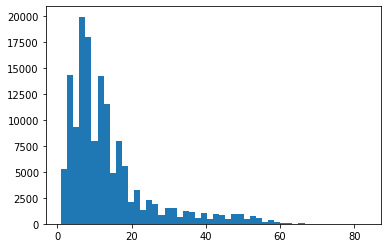

In [46]:
# 리뷰 길이 histogram
plt.hist([len(review) for review in X_train_seq], bins=50)
plt.show()

In [47]:
# 리뷰 최대 길이 구하기
print(max(len(review) for review in X_train_seq))

83


In [48]:
X_train_padding = pad_sequences(X_train_seq, maxlen=40)
X_test_padding = pad_sequences(X_test_seq, maxlen=40)

In [49]:
X_train_padding[:3]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   24,
          64,  908,   30,  211,   12,   25,  702],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,  982,  482,  492,  639,    1,  107,
        1566,   45,  871,  954,    8,   35,  362],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   16,  189]], dtype=int32)

# 2. LSTM 모델 생성, 학습하기

In [50]:
from keras import models, layers

model = models.Sequential()
model.add(layers.Embedding(vocab_size, 100, input_length=40))  # (어휘 사전 크기, 임베딩 벡터 크기, 시퀀스 길이)
model.add(layers.LSTM(128))
model.add(layers.Dense(1, activation='sigmoid'))

In [51]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(X_train_padding, y_train, epochs=10,
                    validation_split=0.2,
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/10
3642/3642 [==============================] - 37s 8ms/step - loss: 0.3755 - accuracy: 0.8305 - val_loss: 0.3311 - val_accuracy: 0.8550
Epoch 2/10
3642/3642 [==============================] - 28s 8ms/step - loss: 0.2789 - accuracy: 0.8823 - val_loss: 0.3268 - val_accuracy: 0.8581
Epoch 3/10
3642/3642 [==============================] - 28s 8ms/step - loss: 0.2255 - accuracy: 0.9084 - val_loss: 0.3425 - val_accuracy: 0.8594
Epoch 4/10
3642/3642 [==============================] - 28s 8ms/step - loss: 0.1771 - accuracy: 0.9300 - val_loss: 0.4031 - val_accuracy: 0.8556


In [52]:
model.evaluate(X_test_padding, y_test)

1534/1534 [==============================] - 6s 4ms/step - loss: 0.3330 - accuracy: 0.8564


[0.3330391049385071, 0.8563947081565857]

# 3. 모델 예측하기

In [53]:
# 리뷰 예측하는 함수
def my_predict(sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z ]','', sentence)          # 정규표현식 적용
  new_sentence = mecab.morphs(new_sentence)                                 # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords]   # 불용어 제거
  print(new_sentence)
  encoding_data = tokenizer.texts_to_sequences([new_sentence])              # 정수 인코딩
  padding_data = pad_sequences(encoding_data, maxlen=40)                    # 패딩
  print('결과 :', model.predict(padding_data))                              # 모델 예측

In [54]:
my_predict('이 영화 개꿀잼 ㅎㅎ')

['영화', '개꿀', '잼', 'ㅎㅎ']
1/1 [==============================] - 0s 363ms/step
결과 : [[0.9938784]]


In [55]:
my_predict('이 영화 핵노잼 ㅠㅠ')

['영화', '핵', '노', '잼', 'ㅠㅠ']
1/1 [==============================] - 0s 15ms/step
결과 : [[0.10405479]]


In [57]:
my_predict('이런 영화가 있다니!!')

['이런', '영화', '있', '다니']
1/1 [==============================] - 0s 17ms/step
결과 : [[0.42926636]]


In [58]:
my_predict('이 영화 또 보고 싶네요')

['영화', '또', '보', '고', '싶', '네요']
1/1 [==============================] - 0s 16ms/step
결과 : [[0.9384383]]


In [59]:
my_predict('시간 낭비인것 같아요')

['시간', '낭비', '인', '것', '같', '아요']
1/1 [==============================] - 0s 16ms/step
결과 : [[0.01380452]]
